### Data Downloading
For our tutorial, we will be utilizing the Cornell Movie-Dialogs Corpus, a vast collection of over 220,000 conversational exchanges between more than 10,000 pairs of characters in various movies and TV shows.

In [40]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")

print("Path to dataset files:", path)

100%|██████████| 9.58M/9.58M [00:02<00:00, 3.50MB/s]

Extracting files...


Path to dataset files: /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1


In [41]:
!ls -r /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1

raw_script_urls.txt           movie_characters_metadata.txt
movie_titles_metadata.txt     chameleons.pdf
movie_lines.txt               README.txt
movie_conversations.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
!mkdir datasets
!mv /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_conversations.txt ./datasets
!mv /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_lines.txt ./datasets

mkdir: .: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mv: rename /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_conversations.txt to ./datasets: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mv: rename /Users/jainendra/.cache/kagglehub/datasets/rajathmc/cornell-moviedialog-corpus/versions/1/movie_lines.txt to ./datasets: No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### To begin our implementation of BERT, we first import the necessary libraries and preprocess the dataset by storing it into memory.

1. The data corpus is divided into two files, ‘movie_conversations.txt’ and ‘movie_lines.txt’.
2. We then split the text in ‘movie_lines.txt’ using a special delimiter (‘+++ $ +++’) to separate the line’s ID, character ID, movie ID, and dialogue text, and store them in a dictionary called line_dic.
3. Next, we generate question-answer pairs by iterating over each conversation in ‘movie_conversations.txt’ and pairing the current line’s text with the next line’s text for each conversation.
4. Finally, we limit the maximum length of the input sequence to 64 tokens, which is a common length used in many NLP tasks, by splitting the text and taking only the first 64 tokens.


In [28]:
import os
from pathlib import Path
import torch
import re
import random
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

MAX_LEN = 64

### loading all data into memory
corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

### splitting text using special lines
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

### generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []
        
        if i == len(ids) - 1:
            break

        first = lines_dic[ids[i]].strip()  
        second = lines_dic[ids[i+1]].strip() 

        qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
        qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
        pairs.append(qa_pairs)

In [30]:
print(pairs[21])

["She's not a...", "Lesbian? No. I found a picture of Jared Leto in one of her drawers, so I'm pretty sure she's not harboring same-sex tendencies."]


## WordPiece Tokenization
The initial stage of creating a fresh BERT model involves training a new tokenizer. Tokenization is the process of breaking down a text into smaller units called “tokens,” which are then converted into a numerical representation. An example of this would be splitting the sentence

 “I like surfboarding!” → [‘[CLS]’, ‘i’, ‘like’, ‘surf’, ‘##board’, ‘##ing’, ‘!’, ‘[SEP]’] → [1, 48, 250, 4033, 3588, 154, 5, 2]

A tokenized BERT input always starts with a special [CLS] token and ends with a special [SEP] token, which are used for specific purposes that will be explained later. BERT employs a WordPiece tokenizer, which can split a single word into multiple tokens. For instance, in the example given earlier, the word “surfboarding” is broken down into ['surf', '##boarding', '##ing']. This technique helps the model to understand that words like surfboardand snowboardhave shared meaning through the common wordpiece ##board. By referring to the explanation from HuggingFace, WordPiece computes a score for each pair, using the following

score = (freq_of_pair) / (freq_of_first_element × freq_of_second_element)

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

To train the tokenizer, the BertWordPieceTokenizer from the transformer library was used with the steps below:

1. Saving the conversation text into multiple .txt files (with batch of N=10000)
2. Define BertWordPieceTokenizer with some parameters likeclean_text to remove control characters, handle_chinese_chars to include spaces around Chinese characters, stripe_accents to remove accents and
3. make é → e, ô → o, andlowercase to view capital and lowercase characters as equal.
4. Train the tokenizer based on the file path to .txt files with parameters like vocab_size defines the total number of tokens, min_frequency for minimum frequency for a pair of tokens to be merged, 
5. 5special_tokens defines a list of the special tokens that BERT uses, limit_alphabet for a maximum number of different characters, workpieces_prefix the prefix added to pieces of words (like ##ing).

In [32]:
# WordPiece tokenizer

### save data as txt file
os.mkdir('./data')
text_data = []
file_count = 0

for sample in tqdm.tqdm([x[0] for x in pairs]):
    text_data.append(sample)

    # once we hit the 10K mark, save to file
    if len(text_data) == 10000:
        with open(f'./data/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
            fp.write('\n'.join(text_data))
        text_data = []
        file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

### training own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True
)

tokenizer.train( 
    files=paths,
    vocab_size=30_000, 
    min_frequency=5,
    limit_alphabet=1000, 
    wordpieces_prefix='##',
    special_tokens=['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']
    )

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1', 'bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

100%|██████████| 221616/221616 [00:00<00:00, 3108134.35it/s]


/Users/jainendra/miniconda3/envs/genai/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1947: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


**To specifically highlight these special tokens for BERT:**

* CLS stands for classification. It serves as the the Start of Sentence (SOS) and represent the meaning of the entire sentence.
SEP serves as End of Sentence (EOS) and also the separation token between first and second sentences.
* PADto be added into sentences so that all of them would be in equal length. During the training process, please note that the [PAD] token with id of 0 will not contribute to the gradient .
* MASK for word replacement during masked language prediction
* UNK serves as a replacement for token if it’s not being found in the tokenizer’s vocab.

**Pre-Training Strategy (Pre-processing)**
The unique pre-training strategy of BERT are the one of the many reasons for BERT to account for a sentence’s context. BERT does not try to predict the next word in the sentence but instead makes use of the following two strategies:

**1.Masked Language Model (MLM)**
The simple idea by masking 15% of the words with MASK token and predict them. Yet, there is a problem with this masking approach as the model only tries to predict when the [MASK] token is present in the input, while we want the model to try to predict the correct tokens regardless of what token is present in the input. To deal with this issue, out of the 15% of the tokens selected for masking:
- 80% of the tokens are actually replaced with the token [MASK].
- 10% of the time tokens are replaced with a random token.
- 10% of the time tokens are left unchanged.

**2.Next Sentence Prediction (NSP)**
The NSP task forces the model to understand the relationship between two sentences. In this task, BERT is required to predict whether the second sentence is related to the first one. During training, the model is fed with 50% of connected sentences and another half with random sentence sequence.


In [34]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

The code above defines a custom PyTorch Dataset class named BERTDataset, which is intended to be used for training a Bidirectional Encoder Representations from Transformers (BERT) model. The random_word method of the BERTDataset class performs the random replacement of tokens in each sentence using the given tokenizer object. The get_sent method returns a random sentence pair and corresponding is_next label. Finally, the get_corpus_line and get_random_line methods are used to retrieve individual sentences from the input pairs for negative sentence pairs.

It took multiple steps to prepare the data for the two training strategies

* **Step 1**:
Select a random sentence pair, either positive or negative, and save the is_next indicating whether the two sentences are consecutive in the original text or not.
* **Step 2**:
Masking random words in first and second sentences based on predefined probabilities, at the same time recording the actual word as bert_label. After which, it converts the sequence string into integer (list of token ids).

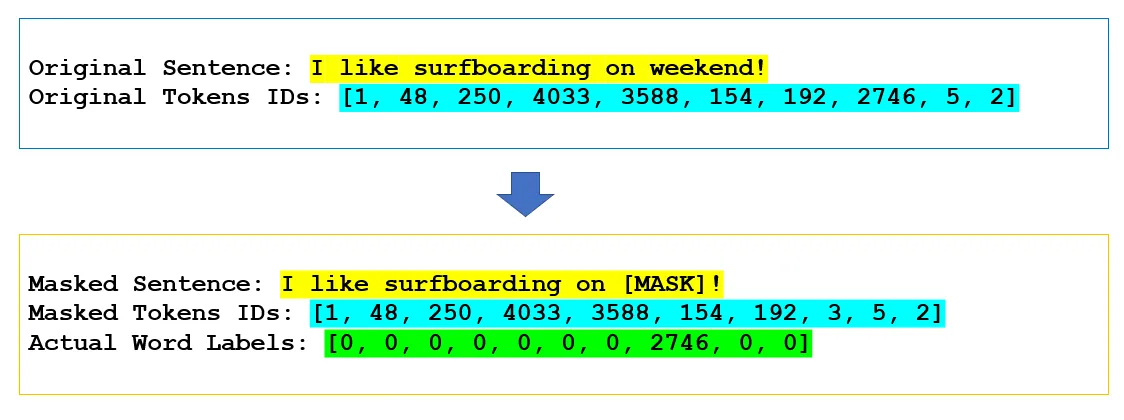

* **Step 3**:
Add special [CLS] and [SEP] tokens to the start and end of each sentence.
* **Step 4**:
Combine first and second sentences as single output (but separated by SEPtoken) and then followed by padding with PAD token to the sentence pairs and labels to max length. At this step, a segment label is created by assigning 1 for first sentence and 2 for second, whereas 0 for padded tokens.


By printing a sample output from the prepared dataset, we will see 4 keys output

* bert_input for tokenized sentences
* bert_label stores original words of selected masking tokens
* segment_label as the identifier for sentence A or B, this allows the model to distinguish between sentences
* is_next as truth label for whether the two sentences are related